In [1]:
import helper
import numpy as np
import matplotlib.pyplot as plt
from Option import Option
import black_scholes as bs
import bopm

In [2]:
ticker = 'MSFT'
df_c, df_p, df_close, val = helper.read_ticker(ticker)

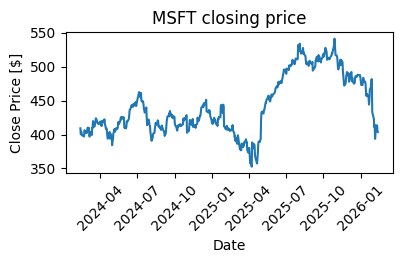

In [3]:
fig1, ax = plt.subplots(figsize=(4,2))
fig1.tight_layout()

ax.set_title(f'{ticker} closing price')
ax.plot(df_close['Date'], df_close['Close'])
ax.set_xlabel('Date')
ax.set_ylabel('Close Price [$]')
ax.tick_params(axis='x', rotation=45)
plt.show()

In [4]:
opt_c = Option(df_c['TTM [d]'] / 365, val['spot'], df_c['strike'], val['sigma'], val['r'], val['div'], 'call', 'eu')
opt_p = Option(df_p['TTM [d]'] / 365, val['spot'], df_p['strike'], val['sigma'], val['r'], val['div'], 'put', 'eu')

# 1. Find call and put price based on historic volatility
df_c['BS price (hist)'] = bs.option_price(opt_c)
df_p['BS price (hist)'] = bs.option_price(opt_p)
df_c['BOPM price (hist)'] = bopm.option_price(opt_c)
df_p['BOPM price (hist)'] = bopm.option_price(opt_p)

# 2. Add greeks
df_c['delta'], df_c['gamma'], df_c['vega'], df_c['theta'], df_c['rho'] = bs.greeks(opt_c)
df_p['delta'], df_p['gamma'], df_p['vega'], df_p['theta'], df_p['rho'] = bs.greeks(opt_p)

# 3. Add probability of profit
df_c['POP'], _ = bs.prob_of_profit(opt_c)
df_p['POP'], _ = bs.prob_of_profit(opt_p)

# 4. Find call and put price based on implied volatility
opt_c.sigma = df_c['impliedVolatility']
opt_p.sigma = df_p['impliedVolatility']
df_c['BS price (implied)'] = bs.option_price(opt_c)
df_p['BS price (implied)'] = bs.option_price(opt_p)
df_c['BOPM price (implied)'] = bopm.option_price(opt_c)
df_p['BOPM price (implied)'] = bopm.option_price(opt_p)

df_c.head()

,Exp.Date,TTM [d],strike,BS price (hist),BS price (implied),BOPM price (hist),BOPM price (implied),bid,ask,market,lastPrice,volume,impliedVolatility,delta,gamma,vega,theta,rho,POP
0,2026-02-13,1.188749,270.0,133.667580,133.908380,133.667580,133.903204,131.45,134.9,133.175,129.00,2.0,3.118166,1.0,1.619963e-157,2.263751e-155,-5.399648,0.879291,0.497575
1,2026-02-13,1.188749,280.0,123.668232,123.916466,123.668232,123.908189,121.45,124.9,123.175,123.98,12.0,2.876956,1.0,1.178683e-130,1.647102e-128,-5.599635,0.911857,0.497532
2,2026-02-13,1.188749,290.0,113.668883,113.926155,113.668883,113.915727,111.40,114.9,113.150,114.08,19.0,2.643558,1.0,3.798939e-107,5.308672e-105,-5.799622,0.944424,0.497489
3,2026-02-13,1.188749,300.0,103.669534,103.936162,103.669534,103.931425,101.40,104.9,103.150,104.16,24.0,2.415043,1.0,1.101787e-86,1.539647e-84,-5.999609,0.976990,0.497446
4,2026-02-13,1.188749,310.0,93.670186,93.947939,93.670186,93.945617,91.40,94.9,93.150,94.17,19.0,2.192387,1.0,5.383032e-69,7.522299e-67,-6.199596,1.009556,0.497404


### Comparison of Black-Scholes Price to Market Price
- If the market price is under the fair value it is underpriced
- The difference is usually eaten away by the spread.

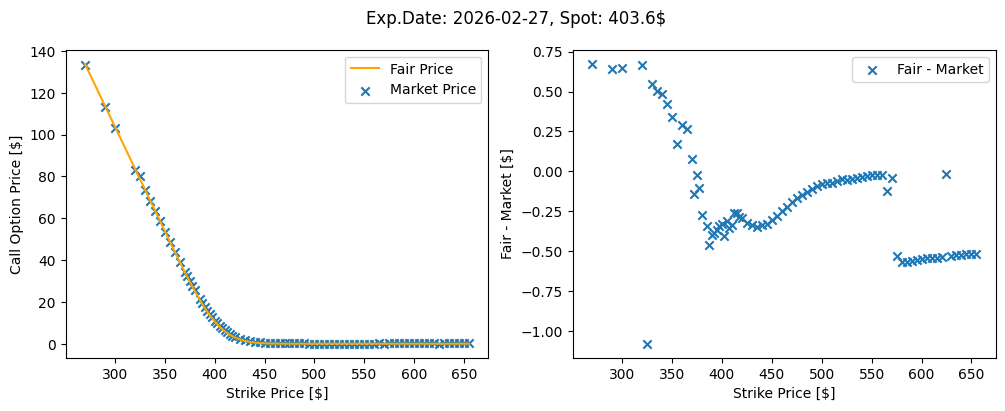

In [5]:
# Example date
# exp_date = df_c['Exp.Date'].iloc[0]
exp_date = df_c['Exp.Date'].iloc[int(df_c.shape[0] / 4)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
fig.suptitle(f'Exp.Date: {exp_date.strftime('%Y-%m-%d')}, Spot: {val['spot']:.1f}$')

df_c__ = df_c[df_c['Exp.Date'] == exp_date]

prices_c = bs.option_price(Option(tau=df_c__['TTM [d]']/365, spot=val['spot'], strike=df_c__['strike'], sigma=val['sigma'], r=0.02))
ax1.plot(df_c__['strike'], prices_c, color='orange', label='Fair Price')
ax1.scatter(df_c__['strike'], df_c__['market'], marker='x', label='Market Price')
ax1.set_xlabel('Strike Price [$]')
ax1.set_ylabel('Call Option Price [$]')
ax1.legend()

ax2.scatter(df_c__['strike'], prices_c - df_c__['market'], marker='x', label='Fair - Market')
ax2.set_xlabel('Strike Price [$]')
ax2.set_ylabel('Fair - Market [$]')
ax2.legend()

plt.show()

### Probability of Profit (POP)
- The probability of profit (POP) is the likelihood that an option trade will be profitable at expiration.
- Not to be confused with the probability of expiring in the money (ITM), which is the likelihood that an option will have intrinsic value at expiration.
- Also not to be confused with the expected return, as the POP does not take into account the potential profit or loss of the trade.

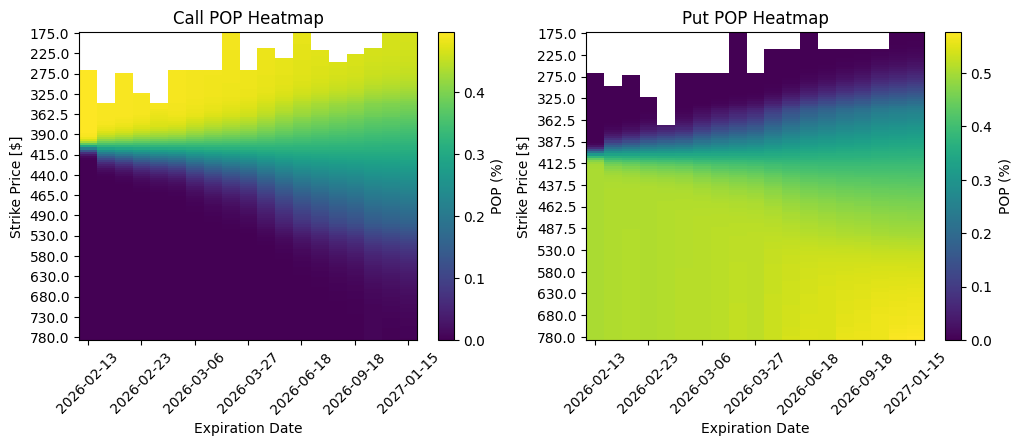

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

pivot_table = df_c.pivot_table(values='POP', index='strike', columns='Exp.Date', aggfunc='mean', fill_value=np.nan).interpolate()
im = ax1.imshow(pivot_table, aspect='auto', interpolation='nearest')
fig.colorbar(mappable=im, ax=ax1, label='POP (%)')
ax1.set_title('Call POP Heatmap')
ax1.set_xlabel('Expiration Date')
ax1.set_ylabel('Strike Price [$]')
ax1.set_xticks(range(0, len(pivot_table.columns), 3), pivot_table.columns[::3].strftime('%Y-%m-%d'), rotation=45)
ax1.set_yticks(range(0, len(pivot_table.index), 10), pivot_table.index[::10])

pivot_table = df_p.pivot_table(values='POP', index='strike', columns='Exp.Date', aggfunc='mean', fill_value=np.nan).interpolate()
im = ax2.imshow(pivot_table, aspect='auto', interpolation='nearest')
fig.colorbar(mappable=im, ax=ax2, label='POP (%)')
ax2.set_title('Put POP Heatmap')
ax2.set_xlabel('Expiration Date')
ax2.set_ylabel('Strike Price [$]')
ax2.set_xticks(range(0, len(pivot_table.columns), 3), pivot_table.columns[::3].strftime('%Y-%m-%d'), rotation=45)
ax2.set_yticks(range(0, len(pivot_table.index), 10), pivot_table.index[::10])
plt.show()

### Parity
- Parity indicates how far the market value of a option deviates from its fair value.
- A parity of 0 means the option is fairly priced, while a positive or negative parity indicates that the option is overpriced or underpriced, respectively.
- parity = call - put + discounted strike price - spot price.
- Effectively the parity is compensated by the spread.

In [7]:
df__ = df_c.merge(df_p, 'inner', on=['Exp.Date', 'TTM [d]', 'strike'], suffixes=('_c', '_p'))
df__['Parity'] = df__['BS price (hist)_c'] - df__['BS price (hist)_p'] + df__['strike'] * np.exp(-val['r'] * df__['TTM [d]'] / 365) - val['spot']
df__['Parity_market'] = df__['market_c'] - df__['market_p'] + df__['strike'] * np.exp(-val['r'] * df__['TTM [d]'] / 365) - val['spot']
df__['Parity_real'] = df__['ask_c'] - df__['bid_p'] + df__['strike'] * np.exp(-val['r'] * df__['TTM [d]'] / 365) - val['spot']
df__ = df__[['Exp.Date', 'TTM [d]', 'strike', 'bid_c', 'ask_c', 'market_c', 'bid_p', 'ask_p', 'market_p', 'Parity', 'Parity_market', 'Parity_real']]
df__.head()

,Exp.Date,TTM [d],strike,bid_c,ask_c,market_c,bid_p,ask_p,market_p,Parity,Parity_market,Parity_real
0,2026-02-13,1.188749,270.0,131.45,134.9,133.175,0.0,0.01,0.005,0.0,-0.497580,1.232420
1,2026-02-13,1.188749,280.0,121.45,124.9,123.175,0.0,0.01,0.005,0.0,-0.498232,1.231768
2,2026-02-13,1.188749,290.0,111.40,114.9,113.150,0.0,0.01,0.005,0.0,-0.523883,1.231117
3,2026-02-13,1.188749,300.0,101.40,104.9,103.150,0.0,0.01,0.005,0.0,-0.524534,1.230466
4,2026-02-13,1.188749,310.0,91.40,94.9,93.150,0.0,0.02,0.010,0.0,-0.530186,1.229814


### Volatility Analysis
- Out-of-the-money (OTM) options tend to have higher implied volatility than at-the-money (ATM) options.
- They assume a higher probability of a large price move.
- Volatility smile/skew: implied volatility vs strike price
- Volatility surface: 3D plot of implied volatility vs strike and time

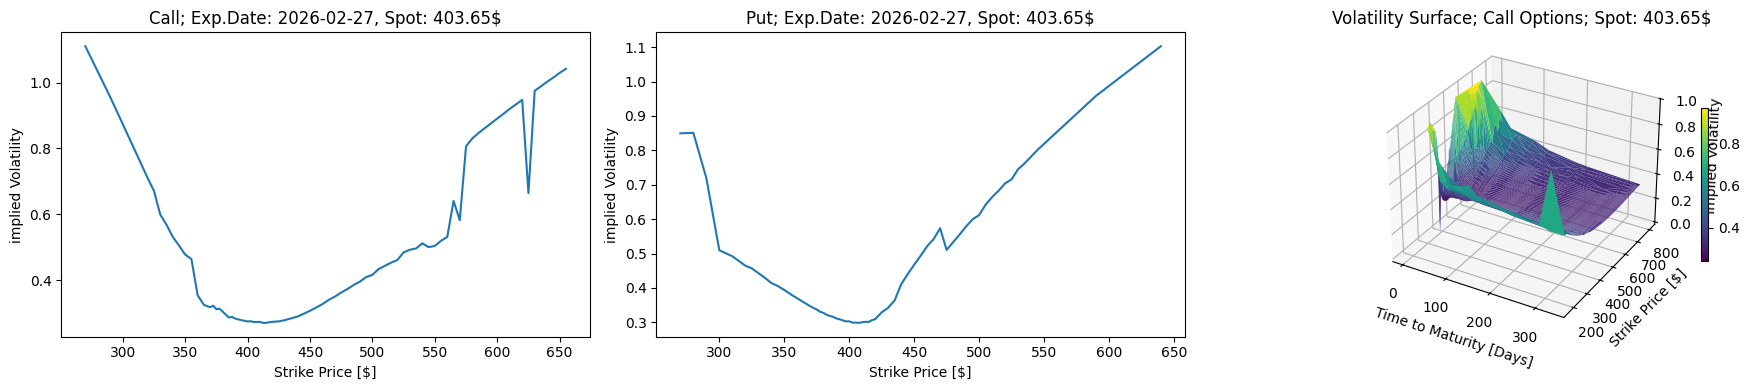

In [8]:
from matplotlib import cm
exp_date = df_c['Exp.Date'].iloc[int(df_c.shape[0] / 4)]
filtered_df_c = df_c[df_c['Exp.Date'] == exp_date]
filtered_df_p = df_p[df_p['Exp.Date'] == exp_date]
fig = plt.figure(figsize=(18, 4))

ax1 = fig.add_subplot(1, 3, 1)
ax1.plot(filtered_df_c['strike'], filtered_df_c['impliedVolatility'])
ax1.set_title(f'Call; Exp.Date: {exp_date.strftime('%Y-%m-%d')}, Spot: {val['spot']:.2f}$')
ax1.set_xlabel('Strike Price [$]')
ax1.set_ylabel('implied Volatility')

ax2 = fig.add_subplot(1, 3, 2)
ax2.plot(filtered_df_p['strike'], filtered_df_p['impliedVolatility'])
ax2.set_title(f'Put; Exp.Date: {exp_date.strftime('%Y-%m-%d')}, Spot: {val['spot']:.2f}$')
ax2.set_xlabel('Strike Price [$]')
ax2.set_ylabel('implied Volatility')

ax3 = fig.add_subplot(1, 3, 3, projection='3d')
clean_df_c = df_c[df_c['impliedVolatility'] < 1].dropna()
surf = ax3.plot_trisurf(clean_df_c['TTM [d]'], clean_df_c['strike'], clean_df_c['impliedVolatility'], cmap=cm.viridis)
ax3.set_title(f'Volatility Surface; Call Options; Spot: {val['spot']:.2f}$')
ax3.set_xlabel('Time to Maturity [Days]')
ax3.set_ylabel('Strike Price [$]')
ax3.set_zlabel('Implied Volatility')
fig.colorbar(surf, shrink=0.5)

plt.tight_layout()
plt.show()